## 时序预测实验

这次实验对电力变压器温度（ETT）的相关数据进行预测。

**ETT数据集** ：该数据集由来自中国两个独立县的两年数据组成。

- ETTh1, ETTh2：每条数据之间的时间间隔是1小时。
- ETTm1, ETTm2：每条数据之间的时间间隔是15分钟。

每个文件都是7维数据，前6列表示电力变压器的不同指标，最后1列是电力变压器温度。

In [1]:
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. 数据集准备

使用ETTh1.csv数据集。让我们先看看数据集中的数据是什么样的：

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

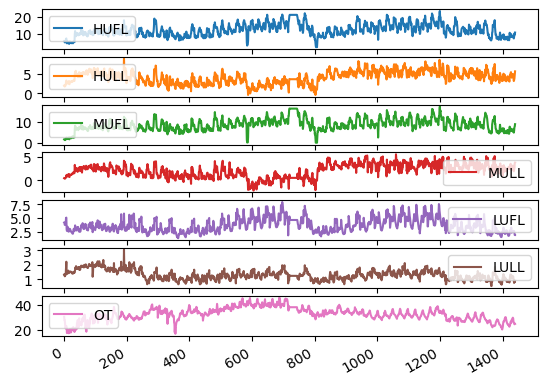

In [2]:
# 可视化ETTh1.csv数据
etth1_path = '../dataset/ETT-small/ETTh1.csv'
df_raw = pd.read_csv(etth1_path)
# 由于数据太长只取前两个月的数据可视化
df_raw = df_raw[:1440]  # 30*2*24=1440
df_raw.plot(subplots=True)

使用pandas读取出来的数据是numpy的数组类型，我们需要将其转换成mindspore能够处理的Tensor类型。这时就需要自定义数据集，首先我们先写一个构建一个可以读取数据和返回数据的类。

In [5]:
from os import path
from sklearn.preprocessing import StandardScaler

In [6]:
class TSDataset:
    def __init__(self, root_path, data_path, size=None, scale=True, flag='train'):
        self.root_path = root_path
        self.data_path = data_path
        self.scale = scale
        self.scaler = StandardScaler()
        if size is None:
            self.seq_len = 96
            self.pred_len = 32
        else:
            self.seq_len = size[0]
            self.pred_len = size[1]
        assert flag in ['train', 'test']
        type_map = {'train': 0, 'test': 1}
        self.set_type = type_map[flag]

        # 初始化数据集
        self.__read_data__()


    def __read_data__(self):
        df_raw = pd.read_csv(path.join(self.root_path, self.data_path))
        df_len = df_raw.shape[0]
        # 以8:2的比例划分成训练集和测试集
        border1s = [0, int(df_len * 0.8) - self.seq_len]
        border2s = [int(df_len * 0.8), df_len]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        # 拿到除了时间戳列的其他列数据
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]

        # 是否归一化
        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        # (x, y)训练样本
        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]

        # self.data_x = ms.Tensor(self.data_x, dtype=ms.float32)
        # self.data_y = ms.Tensor(self.data_y, dtype=ms.float32)

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

接下使用mindspore中GeneratorDataset类，把上面的TSDataset转换成训练过程中适合读取数据的类。

GeneratorDataset官方文档：[mindspore](https://www.mindspore.cn/docs/zh-CN/r2.0.0-alpha/api_python/dataset/mindspore.dataset.GeneratorDataset.html)

In [8]:
from mindspore.dataset import GeneratorDataset
import mindspore.dataset.transforms.c_transforms as C2

In [9]:
def datapipe(root_path, data_path, size=None, scale=True, batch_size=32, flag='train'):
    data = TSDataset(root_path, data_path, size, scale, flag)
    if flag == 'train':
        shuffle = True
    else:
        shuffle = False
    data_loader = GeneratorDataset(source=data, column_names=['seq', 'label'], shuffle=shuffle)
    data_loader = data_loader.batch(batch_size, drop_remainder=True)
    
    # data_loader = data_loader.map(ToType(ms.float32), input_columns='seq')
    # data_loader = data_loader.map(ToType(ms.float32), input_columns='label')
    type_cast_op = C2.TypeCast(ms.float32)
    data_loader = data_loader.map(operations=type_cast_op, input_columns='seq', num_parallel_workers=8)
    data_loader = data_loader.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    return data_loader

现在，数据集已经准备好了。下面的代码是读取数据的方法。

In [10]:
train_loader = datapipe(root_path='../dataset/ETT-small', data_path='ETTh1.csv', size=[96, 10], batch_size=32)
train_loader.create_tuple_iterator()
for batch, (seq, label) in enumerate(train_loader.create_tuple_iterator()):
    print(f'batch = {batch}, seq = {seq.shape}, {seq.dtype}, label = {label.shape}, {label.dtype}')
    break

batch = 0, seq = (32, 96, 7), Float32, label = (32, 10, 7), Float32


### 2. 模型定义

这次实验使用了两个模型：MLP和GRU，一个是全连接线性神经网络，一个是循环神经网络。但是，由于时间关系，本次实验只训练MLP模型。

除了实验中训练好的mlp模型，还另外提供了在不同参数下训练好的模型。

#### 2.1. MLP模型

In [11]:
class MLP(nn.Cell):
    def __init__(self, in_channels=96, out_channels=32, hidden_channels=128):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.fc1 = nn.Dense(in_channels, hidden_channels)
        self.network = nn.SequentialCell(
            nn.Dense(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dense(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dense(hidden_channels, out_channels)
        )

    def construct(self, x):
        x = x.transpose((0, 2, 1))
        out = self.network(x)
        out = out.transpose((0, 2, 1))
        return out

In [12]:
# 测试输入输出
mlp = MLP(in_channels=96, out_channels=10)
x = ms.numpy.randn((32, 96, 7))
print(x.shape)
out = mlp(x)
print(out.shape)

(32, 96, 7)
(32, 10, 7)


#### 2.2. GRU模型

In [13]:
class My_GRU(nn.Cell):
    def __init__(self, num_layers, hidden_dim, seq_len, pred_len):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.pred_len = pred_len

        self.lstm = nn.GRU(input_size=self.seq_len, hidden_size=self.hidden_dim,
                            num_layers=self.num_layers, batch_first=True)

        self.fc = nn.Dense(self.hidden_dim, self.pred_len)

    def construct(self, x):  # (batch, seq_len, channels)
        x = x.transpose((0, 2, 1))
        h_0 = ms.numpy.zeros((self.num_layers, x.shape[0], self.hidden_dim))
        output, _ = self.lstm(x, h_0)  # (b,c,h) (3,b,h)
        out = self.fc(output)
        out = out.transpose((0, 2, 1))
        return out  # (batch, pred_len, channels)

In [14]:
# 测试GRU的输入输出
gru = My_GRU(num_layers=1,
                   hidden_dim=128,
                   seq_len=96,
                   pred_len=10)
x = ms.numpy.randn((32, 96, 7))
print(x.shape)
out = gru(x)
print(out.shape)

(32, 96, 7)
(32, 10, 7)


### 3. 训练

时序预测任务通常使用MSE损失进行训练，预测结果的好坏通常使用预测值和真实值之间的MSE和MAE指标来评判。

接下来定义训练过程需要的参数配置

In [18]:
from mindspore.train import Model
from mindspore.train.callback import LossMonitor

In [19]:
# 初始化MLP模型
mlp = MLP(in_channels=96, out_channels=10, hidden_channels=128)
# 设置训练参数
epochs = 3
batch_size = 64
learning_rate = 1e-2
loss_fn = nn.MSELoss()
optimizer = nn.Adam(mlp.trainable_params(), learning_rate=learning_rate)
# 初始化训练集和测试集
train_loader = datapipe(root_path='../dataset/ETT-small', data_path='ETTh1.csv', size=[96, 10], batch_size=batch_size, flag='train')

In [16]:
model = Model(mlp, loss_fn=loss_fn, optimizer=optimizer, metrics={'mse'})
model.train(epochs, train_loader, callbacks=[LossMonitor(100)])
ms.save_checkpoint(mlp, './mlp_h128.ckpt')

epoch: 1 step: 100, loss is 0.18322093784809113
epoch: 1 step: 200, loss is 0.229269877076149
epoch: 2 step: 84, loss is 0.22574147582054138
epoch: 2 step: 184, loss is 0.23876476287841797
epoch: 3 step: 68, loss is 0.20934732258319855
epoch: 3 step: 168, loss is 0.19913740456104279


### 4. 测试

在测试过程中，我们先加载训练好的模型，然后输入测试数据，对数据进行可视化。

In [20]:
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, mae_loss = 0, 0, 0
    mae = nn.MAELoss()
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        # visual_only_pred(label, pred)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        mae_loss += mae(pred, label).asnumpy()
    test_loss /= num_batches
    mae_loss /= num_batches
    print(f"Test: Avg MSE loss: {test_loss:>8f}, MAE loss: {mae_loss:>8f} \n")

In [30]:
# 加载训练好的模型
model = MLP(in_channels=96, out_channels=10, hidden_channels=128)
param_dict = ms.load_checkpoint('./mlp_h128.ckpt')
ms.load_param_into_net(model, param_dict)

[]

In [31]:
# 在整个测试集上测试
test_loader = datapipe(root_path='../dataset/ETT-small', data_path='ETTh1.csv', size=[96, 10], batch_size=batch_size, flag='test')
test_loop(model, test_loader, loss_fn)

Test: Avg MSE loss: 0.298273, MAE loss: 0.365157 



In [32]:
# 加载测试数据
test_iter = datapipe(root_path='../dataset/ETT-small', data_path='ETTh1.csv', size=[96, 10], batch_size=1, flag='test')
test_iter = test_iter.create_tuple_iterator()

In [37]:
# 可视化函数
def visual_only_pred(label, pred, title=None, legend=None):
    # 先定义子图
    label = label.transpose((0, 2, 1))
    pred = pred.transpose((0, 2, 1))
    total_dim = pred.shape[1]
    subplots = []
    for i in range(total_dim):
        s = int(f'{total_dim}1{i+1}')
        subplots.append(s)
    # 转换成numpy
    x = np.arange(label.shape[-1])
    plt.figure(figsize=(10, 12))
    # 画每个维度的子图
    for i in range(total_dim):
        plt.subplot(subplots[i])
        plt.title(f'dim_{i}')
        tmp_label = label[0, i, :]
        tmp_pred = pred[0, i, :]
        plt.plot(x, tmp_label, label='Label')
        plt.plot(x, tmp_pred, label='Pred')
        plt.legend()

    plt.show()

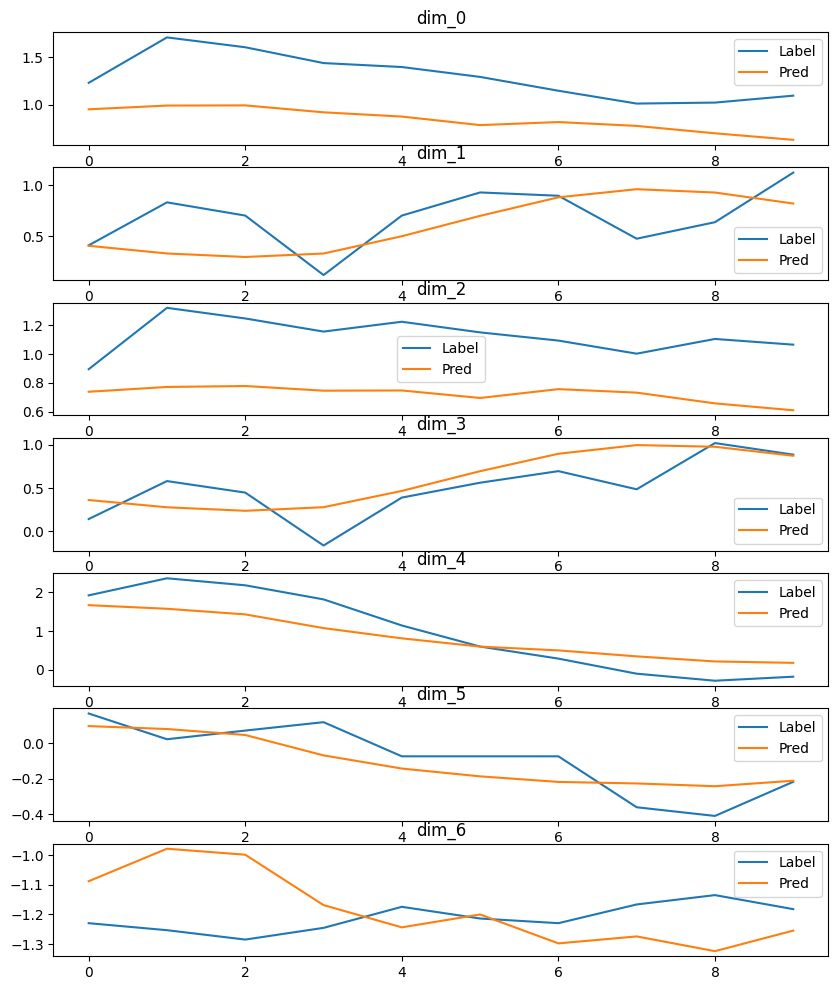

In [38]:
# 把batch大小设置为1，测试模型
seq, label = next(test_iter)
pred = model(seq)
visual_only_pred(label, pred)

### 5. 本次实验任务

除了上面你们自己训练好的'./mlp_h128.ckpt'模型，在ckpt目录下还提供了如下参数的模型：

- mlp_h512.ckpt：隐层维度是512。
- gru_h128.ckpt：num_layers是1，隐层维度是128。如何加载：
    ```python
        gru_h128 = My_GRU(num_layers=1, hidden_dim=128, seq_len=96, pred_len=10)
        param_dict = ms.load_checkpoint('./gru_h128.ckpt')
        ms.load_param_into_net(gru_h128, param_dict)
    ```

直接使用上面加载模型参数的方法，加载上述三个模型，完成下面的任务：

1. 测试三个模型在测试集上的MAE和MAE指标。（ETTh1.csv）
2. 在ETTh2.csv上训练一个2层，隐层维度是128的gru模型，并在测试集上完成测试。